In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

In [2]:
from model.layers import NestedDropout
from model.cmpnts import MLP, SNMLP
from model.layers import SNLinearCombo
from toy_experiment import DynamicPruningAE, DynamicPruningAE_v2, generate_configs
from torch.linalg import svd
from torch.utils.data import DataLoader

# 2D
## 1D Manifold

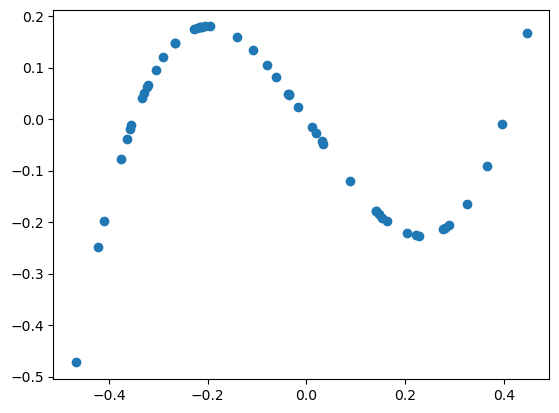

In [3]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
# Y = X + 5 * X ** 3 
Y = 10 * (X-0.4) * X * (X+0.35)

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [5]:
configs = generate_configs(2, [32]*4, 'prune', lr=1e-4)
configs['beta'] = 0.9
configs['z_t'] = 3e-3
configs['r_t'] = 3e-3
ae = DynamicPruningAE_v2(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

data = torch.stack([X, Y], dim=-1)
dataloader = DataLoader(data, batch_size=100, shuffle=True)

ae.fit(dataloader, 10000)

Training prune: 100%|██████████████████████████████| 10000/10000 [00:47<00:00, 211.49it/s, rec=9.82e-7, spar=0.836]


In [6]:
ae._zstd_, ae._p

(tensor([8.3766e-01, 5.6052e-45]), tensor([False,  True]))

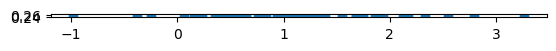

In [7]:
ae.eval()

z = ae.encode(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [8]:
z.max(0)[0] - z.min(0)[0]

tensor([4.2428, 0.0000], grad_fn=<SubBackward0>)

In [9]:
z.T.cov()

tensor([[0.6994, 0.0000],
        [0.0000, 0.0000]], grad_fn=<SqueezeBackward0>)

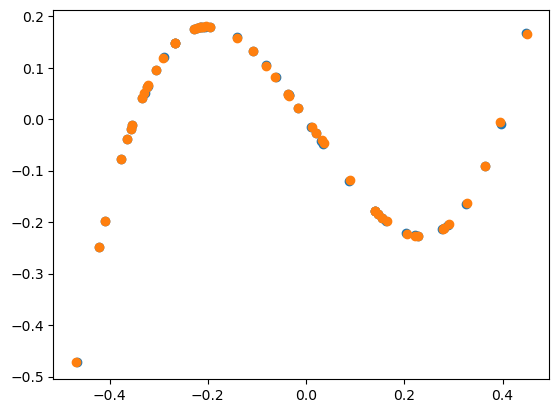

In [10]:
rec = ae.decode(z).detach().numpy()
plt.scatter(X.numpy(), Y.numpy())
plt.scatter(rec[:, 0], rec[:, 1])

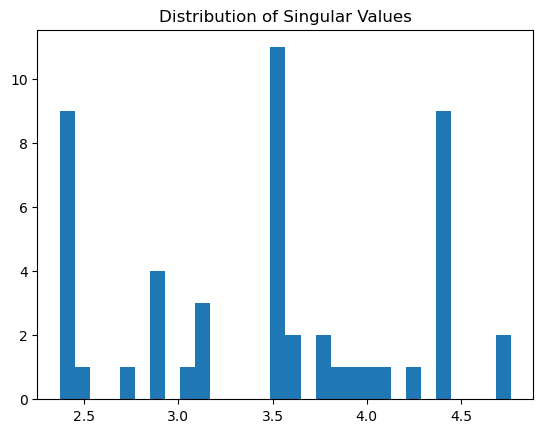

In [11]:
def f(x):
    return ae.encode(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j)[1][0] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

In [12]:
svd(jcb[0])

torch.return_types.linalg_svd(
U=tensor([[1.0000, 0.0000],
        [0.0000, 1.0000]]),
S=tensor([4.2322, 0.0000]),
Vh=tensor([[ 0.8918,  0.4523],
        [-0.4523,  0.8918]]))

In [13]:
jcb[0]

tensor([[3.7745, 1.9144],
        [0.0000, 0.0000]])

# 3D
## 1D

C:\Users\geniu\AppData\Local\Temp\ipykernel_38460\3232837478.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


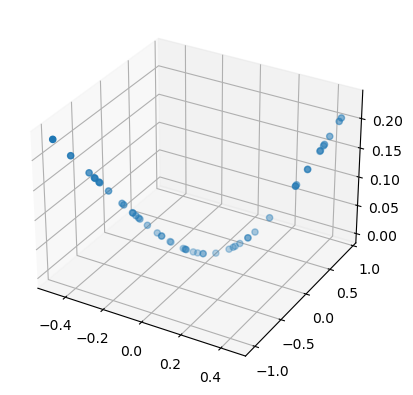

In [14]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = X + 5 * X ** 3
Z = X ** 2
data = torch.stack([X, Y, Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
fig.show()

In [17]:
configs = generate_configs(3, [32]*4, 'prune')
configs['beta'] = 0.9
configs['z_t'] = 3e-3
configs['r_t'] = 3e-3
ae = DynamicPruningAE_v2(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

dataloader = DataLoader(data, batch_size=100, shuffle=True)
ae.fit(dataloader, 10000)

Training prune: 100%|██████████████████████████████| 10000/10000 [00:49<00:00, 200.45it/s, rec=1.88e-6, spar=0.708]


In [18]:
ae._zstd_, ae._p

(tensor([5.6052e-45, 5.6052e-45, 7.1046e-01]), tensor([ True,  True, False]))

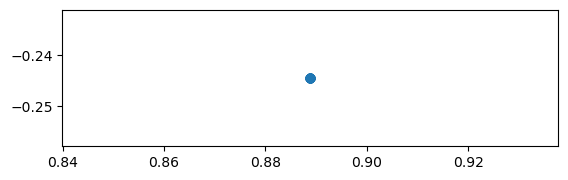

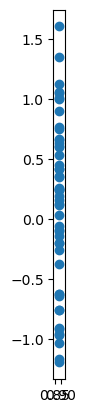

In [19]:
ae.eval()

z = ae.encode(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [20]:
z.T.cov()

tensor([[ 3.2627e-14,  2.7189e-15, -2.6102e-15],
        [ 2.7189e-15,  2.2658e-16,  3.6252e-16],
        [-2.6102e-15,  3.6252e-16,  5.0164e-01]], grad_fn=<SqueezeBackward0>)

C:\Users\geniu\AppData\Local\Temp\ipykernel_38460\1616459218.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


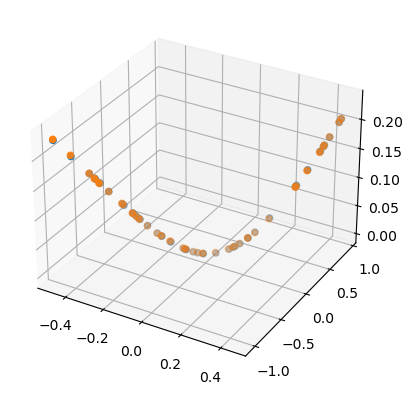

In [21]:
rec = ae.decode(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

## 2D

C:\Users\geniu\AppData\Local\Temp\ipykernel_38460\57433251.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


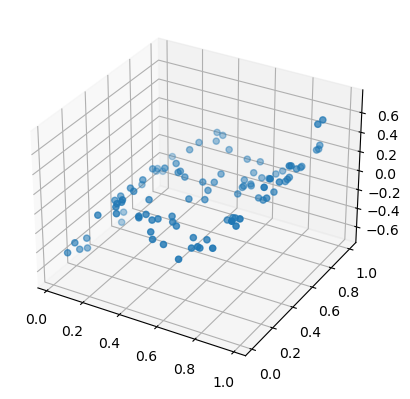

In [22]:
XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) 
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [30]:
configs = generate_configs(3, [32]*4, 'prune', lr=1e-4)
configs['beta'] = 0.9
configs['z_t'] = 3e-3
configs['r_t'] = 3e-3
ae = DynamicPruningAE_v2(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

dataloader = DataLoader(data, batch_size=100, shuffle=True)
ae.fit(dataloader, 10000)

Training prune: 100%|██████████████████████████████| 10000/10000 [00:49<00:00, 202.47it/s, rec=2.54e-5, spar=1.14] 


In [31]:
ae._zstd_, ae._p

(tensor([5.3556e-01, 4.1794e-17, 2.5111e+00]), tensor([False,  True, False]))

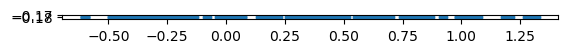

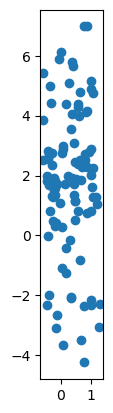

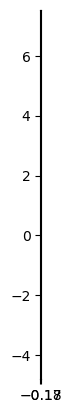

In [32]:
ae.eval()

z = ae.encode(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

C:\Users\geniu\AppData\Local\Temp\ipykernel_38460\3938893466.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


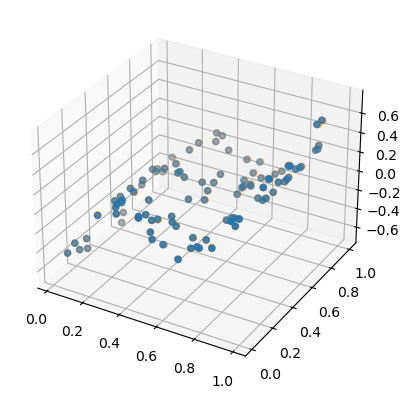

In [26]:
rec = ae.decode(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

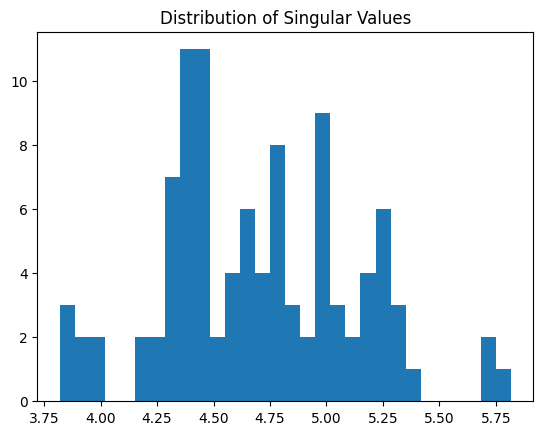

In [118]:
def f(x):
    return ae.encode(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j)[1][0] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## Noise 2D

C:\Users\geniu\AppData\Local\Temp\ipykernel_38460\493637931.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


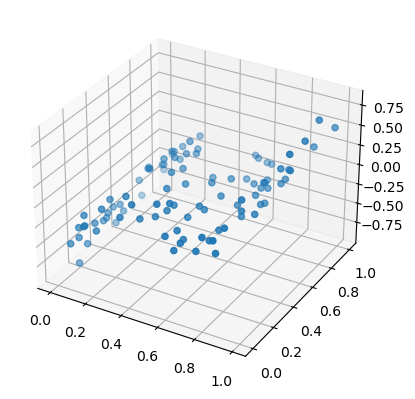

In [33]:
XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) + torch.randn(len(X))/10
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [36]:
configs = generate_configs(3, [32]*4, 'prune', lr=1e-3)
configs['beta'] = 0.9
configs['z_t'] = 5e-3
configs['r_t'] = 3e-2
ae = DynamicPruningAE_v2(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-3])

dataloader = DataLoader(data, batch_size=100, shuffle=True)
ae.fit(dataloader, 10000)

Training prune: 100%|██████████████████████████████| 10000/10000 [00:50<00:00, 196.96it/s, rec=0.000418, spar=0.721]


In [37]:
ae._zstd_, ae._p

(tensor([1.3954e+00, 3.8012e-01, 5.6052e-45]), tensor([False, False,  True]))

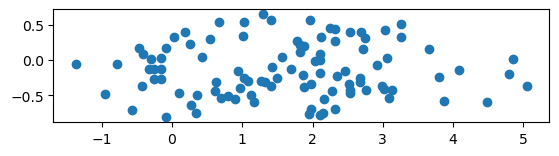

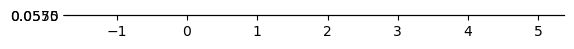

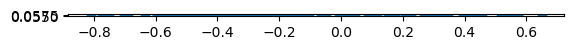

In [38]:
ae.eval()

z = ae.encode(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

C:\Users\geniu\AppData\Local\Temp\ipykernel_38460\3938893466.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


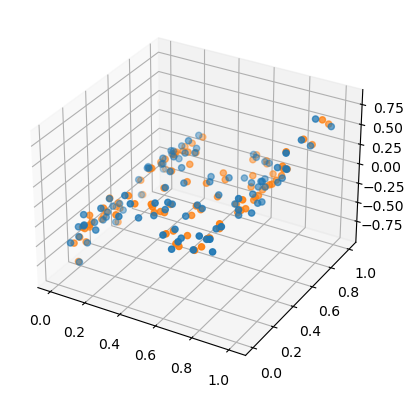

In [39]:
rec = ae.decode(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

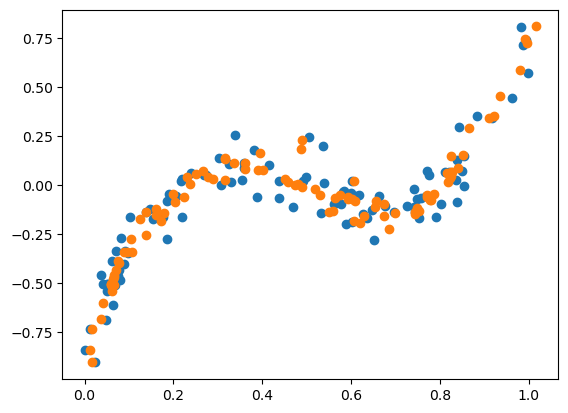

In [40]:
plt.scatter(XY[:,0].numpy(), Z.numpy())
plt.scatter(rec[:, 0], rec[:, 2])
plt.show()